In [1]:
import os 
os.chdir('../../')

In [2]:
from backbones.sana import SANA

# 사용 예
model = SANA()
print(model)

/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
Loading pipeline components...: 100%

In [3]:
import numpy as np

prompts = np.load('prompts/mscoco2017.npz')['arr_0']
prompts = [str(p) for p in prompts[:10]]
prompts

['Athletes sitting on bench at sideline during game.',
 'A couple sits together on a bench next to the water. ',
 'The horses are all behind the barbwire fencing.',
 'A man with a polka dotted tie, dress shirt and wool sweater on.',
 'an elephant in a field of tall grass with trees in the background',
 'two people standing near one another playing nintendo wii',
 'Four bowls filled with different types of foods on top of a table.',
 'An image of boats, and ferries on water.',
 'A very  big kitchen with very bright colors and nice lighting.',
 'A gray train moving down the tracks with great speed.']

In [4]:
from solvers.euler_solver import Euler_Solver

model_fn, noise_schedule, latents = model.get_model_fn(pos_conds=prompts, guidance_scale=4.5)

solver = Euler_Solver(model_fn, noise_schedule, algorithm_type='vector_prediction')
euler_latents = solver.sample(latents, steps=200, skip_type='time_uniform_flow', flow_shift=3.0)
ref_latents = euler_latents
print(euler_latents.shape)

100%|██████████| 200/200 [02:34<00:00,  1.29it/s]

torch.Size([10, 32, 32, 32])


100%|██████████| 11/11 [03:24<00:00, 18.60s/it]


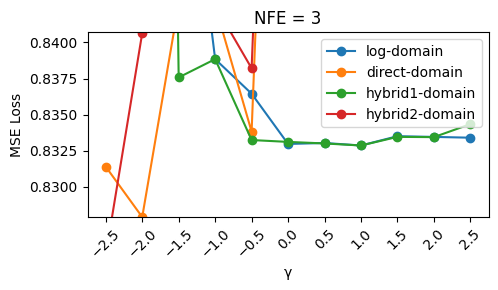

100%|██████████| 11/11 [05:41<00:00, 31.03s/it]


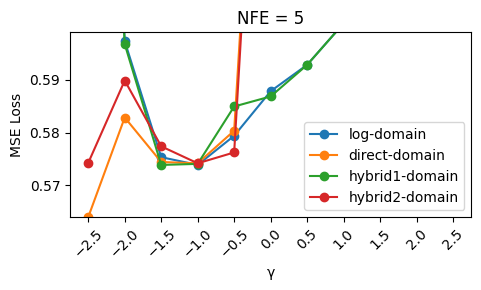

100%|██████████| 11/11 [06:49<00:00, 37.24s/it]


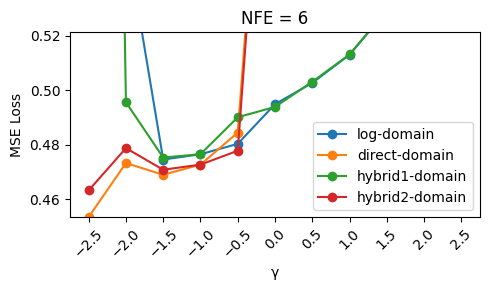

100%|██████████| 11/11 [09:06<00:00, 49.65s/it]


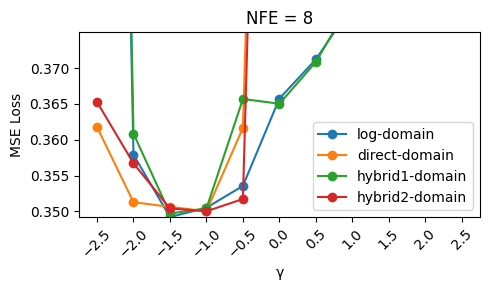

100%|██████████| 11/11 [11:22<00:00, 62.07s/it]


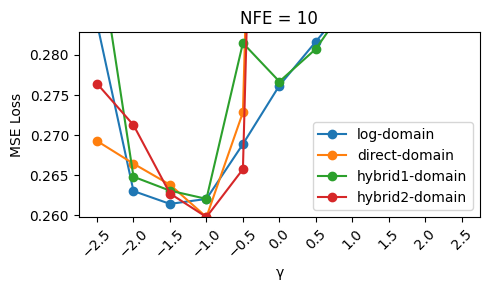

 36%|███▋      | 4/11 [06:07<10:43, 91.93s/it]


KeyboardInterrupt: 

In [5]:
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

from solvers.dual.gdual_log_solver import GDual_Log_Solver
from solvers.dual.gdual_solver import GDual_Solver
from solvers.dual.gdual_hybrid_solver import GDual_Hybrid_Solver
from solvers.dual.gdual_hybrid2_solver import GDual_Hybrid2_Solver


gammas = np.arange(-2.5, 2.6, 0.5)
NFEs   = [3, 5, 6, 8, 10, 12, 15, 20]

for NFE in NFEs:
    log_losses = []
    dir_losses = []
    hyb1_losses = []
    hyb2_losses = []

    for gamma in tqdm(gammas):
        latents_pred = GDual_Log_Solver(model_fn, noise_schedule, 'dual_prediction').sample(latents, steps=NFE, skip_type='time_uniform_flow', flow_shift=3.0, gamma=gamma, order=2)
        log_losses.append(F.mse_loss(ref_latents, latents_pred).item())

        latents_pred = GDual_Solver(model_fn, noise_schedule, 'dual_prediction').sample(latents, steps=NFE, skip_type='time_uniform_flow', flow_shift=3.0, gamma=gamma, order=2)
        dir_losses.append(F.mse_loss(ref_latents, latents_pred).item())

        latents_pred = GDual_Hybrid_Solver(model_fn, noise_schedule, 'dual_prediction').sample(latents, steps=NFE, skip_type='time_uniform_flow', flow_shift=3.0, gamma=gamma, order=2)
        hyb1_losses.append(F.mse_loss(ref_latents, latents_pred).item())

        latents_pred = GDual_Hybrid2_Solver(model_fn, noise_schedule, 'dual_prediction').sample(latents, steps=NFE, skip_type='time_uniform_flow', flow_shift=3.0, gamma=gamma, order=2)
        hyb2_losses.append(F.mse_loss(ref_latents, latents_pred).item())

    plt.figure(figsize=(5,3))
    plt.plot(gammas, log_losses, 'o-', label='log-domain')
    plt.plot(gammas, dir_losses, 'o-', label='direct-domain')
    plt.plot(gammas, hyb1_losses, 'o-', label='hybrid1-domain')
    plt.plot(gammas, hyb2_losses, 'o-', label='hybrid2-domain')

    # 하위 50%만 표시하도록 y축 한정
    all_losses = np.array(log_losses + dir_losses)
    low, high = np.min(all_losses), np.percentile(all_losses, 50)
    plt.ylim(low, high)

    plt.title(f'NFE = {NFE}')
    plt.xlabel('γ')
    plt.ylabel('MSE Loss')
    plt.xticks(gammas, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
